In [140]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import typing as ty
import torchvision

# dark background
plt.style.use('dark_background')

In [141]:
train = torchvision.datasets.MNIST("files/")
test = torchvision.datasets.MNIST("files/", train = False)

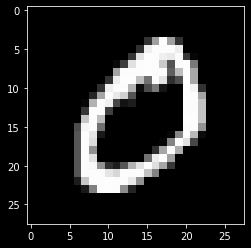

In [142]:
train_dict = { i:[] for i in range(10) }
test_dict = { i:[] for i in range(10) }

for image, label in train:
    train_dict[label].append(np.array(image).flatten())

for image, label in test:
    test_dict[label].append(np.array(image).flatten())

plt.imshow(train_dict[0][0].reshape((28,28)), cmap = 'gray')
plt.show()

In [143]:
# activation functions

def sigmoid(x : ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """sigmoid function
    
    returns 1/(1+exp(-x))"""
    return 1/(1+np.exp(-x))

def tanh(x: ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """tanh function
    
    returns tanh(x)"""
    return np.tanh(x)

def relu(x : ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """ReLU function
    
    returns max(0,x)"""
    return np.maximum(0,x)
    
def softmax(x : np.ndarray) -> np.ndarray:
    """Softmax function
    
    return [e^x_i/sum(e^x_i) for all i]"""
    denom = np.sum(np.exp(x), axis = -1)
    return np.exp(x)/denom



# loss function

def entropy(pmf: np.ndarray) -> float:
    """Returns the entropy of the given pmf 

    The formula used is : -sum p(x) log p(x)

    Example
    --------
    >>> p = np.array([0.5, 0.5])
    >>> entropy(p)
    1.0
    """
    pmf[pmf==0] = 1e-8
    return -np.sum(pmf*np.log2(pmf))

def KL_divergence(p: np.ndarray, q: np.ndarray) -> float:
    """This function returns the KL divergence between the two given pmfs
    
    The formula used is : sum p(x) log p(x)/q(x) 
    
    Example
    -------
    >>> p = np.array([0.5, 0.5])
    >>> q = np.array([0.6, 0.4])
    >>> KL_divergence(p, q)
    0.029446844526784283
    """
    q[q==0] = 1e-8
    p[p==0] = 1e-8
    return np.sum(p * np.log2(p/q)) 

def cross_entropy(p: np.ndarray, q:np.ndarray) -> float:
    """This function returns the cross entropy betwen the two given pmfs
    
    The formula used is : H(p) + D(p||q)
    
    Example
    -------
    >>> p = np.array([0.5, 0.5])
    >>> q = np.array([0.6, 0.4])
    >>> cross_entropy(p, q)
    1.0294468445267844
    """
    return entropy(p)+KL_divergence(p, q)


In [144]:
# a = np.ones((3,8))
# sigmoid(a)

In [145]:
# activation functions derivatives

def sigmoid_der(x : ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """sigmoid function derivative"""    
    return np.exp(-x)/(1+np.exp(-x))**2

def tanh_der(x: ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """tanh function derivative"""
    return 1 - np.tanh(x)**2

def relu_der(x : ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """ReLU function derivative"""
    return (x>=0).astype(int)
    
def softmax_der(x : np.ndarray) -> np.ndarray:
    """Softmax function derivative"""
    denom = np.sum(np.exp(x))
    return np.exp(x)/denom


In [146]:
class mlp:
    @classmethod
    def __init__(self) -> None:
        self.layers = []
        self.loss_func = None
        self.weights = []
        self.bias = []
        self.batch_size = 50
        self.lr = None

    @staticmethod
    def shuffle(input :np.ndarray, labels:np.ndarray) -> np.ndarray:
        """Shuffles the data"""
        l = len(input)
        permutation = np.random.permutation(l)
        input = input[permutation]
        labels = labels[permutation]
        return input, labels

    @classmethod
    def addLayer(self, out_size : int, activation_func : str, in_size : int = None):
        """
        out_size is the size of output from this layer
        in_size is the size of input, it should be defined for the input layer
        """
        dispatcher = {"sigmoid": sigmoid, "tanh":tanh, "softmax": softmax, "relu": relu}
        self.layers.append((out_size, dispatcher[activation_func], in_size))

    @classmethod
    def compile(self, loss_func : str, learning_rate : int):
        """
        This function compiles the program, as in adds weights to the layers
        """
        factor = 10000
        dispatcher = {"cross_entropy": cross_entropy}
        self.loss_func = dispatcher[loss_func]
        self.lr = learning_rate
        W = np.random.random(size = (self.layers[0][0], self.layers[0][2]))/factor
        self.weights.append(W)
        self.bias.append(np.random.random(size = (self.layers[0][0], ))/factor)
        for idx in range(1, len(self.layers)):
            prevlayer = self.layers[idx-1]
            layer = self.layers[idx]
            W = np.random.random(size = (layer[0], prevlayer[0]))/factor
            self.weights.append(W)
            bias = np.random.random(size = (layer[0],))/factor
            self.bias.append(bias)
        self.weights = np.array(self.weights, dtype = object)
        self.bias = np.array(self.bias, dtype = object)
    
    @classmethod
    def forwardpass(self, input: np.ndarray):
        ret = [input]
        for weight, bias, layer in zip(self.weights, self.bias, self.layers):
            try:
                input = (weight @ input) + bias
            except:
                print(weight.shape, input.shape, bias.shape)
                raise ValueError("dhfih")
            activation_func = layer[1]
            input = activation_func(input)
            ret.append(input)
        return ret


    @classmethod
    def fit(self, X: np.ndarray, Y: np.ndarray, epochs = 10, num_classes = 10) -> None:
        """
        This function will do backpropgation for given number of epochs
        Y should be array of scalars
        """
        X,Y = self.shuffle(X,Y)
        train = X[:int(X.shape[0]*0.8)]
        labels = Y[:int(X.shape[0]*0.8)]
        batches = np.arange(0, len(train), self.batch_size)
        
        dispatcher = {sigmoid : sigmoid_der}

        # number of layers
        num_layers = self.layers.__len__()

        for epoch in range(epochs):
            print("Epoch: #{}".format(epoch+1))

            # shuffling the data
            train, labels = self.shuffle(train, labels)

            grad_weights = [0] * num_layers #np.zeros(num_layers)
            grad_bias = [0] * num_layers #np.zeros(num_layers)

            for idx in batches: 
                batch_X = train[idx : idx+self.batch_size]
                batch_label  = labels[idx : idx+self.batch_size]
                for x,y in zip(batch_X, batch_label):
                    x_layers = self.forwardpass(x)
                    delta = [0] * num_layers #np.zeros(num_layers)
                    one_hot = np.zeros(num_classes)
                    one_hot[y] = 1
                    one_hot = y
                    delta[-1] = x_layers[-1] - one_hot

                    grad_weights[-1] += delta[-1]@x_layers[-1].T
                    grad_bias[-1] += delta[-1]

                    for layer in range(num_layers-2,-1,-1):
                        delta[layer] = ((self.weights[layer+1].T @ delta[layer+1]) * dispatcher[self.layers[layer][1]](self.weights[layer]@x_layers[layer]+self.bias[layer]))
                        delta[layer].shape = (delta[layer].shape[0],1)
                        x_layers[layer].shape = (x_layers[layer].shape[0],1)
                        grad_weights[layer] += delta[layer][0]@x_layers[layer].T
                        grad_bias[layer] += delta[layer]
                        # return grad_weights[layer].shape, x_layers[layer].shape,
                        
                grad_weights = [q/self.batch_size for q in grad_weights]
                grad_bias = [q/self.batch_size for q in grad_bias]
                
                
                temp1 = [self.lr * q for q in grad_weights]
                temp2 = [self.lr * q for q in grad_bias]

                
                self.weights -= np.array(temp1, dtype = object)
                self.bias -= np.array(temp2, dtype = object)
                    
                    

            loss = self.evaluate(X[int(X.shape[0]*0.8):], Y[int(X.shape[0]*0.8):])
            print(f'Loss : {loss}')
    @classmethod
    def evaluate(self, x, y):
        p = []
        for xx in x:
            p.append(self.predict(xx))

        loss = 0
        for i,yy in enumerate(y):
            if p[i][yy]!=0:
                loss -= yy*np.log(p[i][yy])
        return loss

    @classmethod
    def predict(self, input : np.ndarray) -> np.ndarray:
        """Returns predicted labels"""
        for weight, bias, layer in zip(self.weights, self.bias, self.layers):
            # print(input.shape, weight.shape)
            input = (weight @ input.T).T + bias
            activation_func = layer[1]
            input = activation_func(input)
        return input
    

In [147]:
classifier = mlp()
classifier.addLayer(49, 'sigmoid', 784)
classifier.addLayer(10, 'softmax', 49)
classifier.compile('cross_entropy', 0.01)
# aaa = np.array([train_dict[0][0], train_dict[1][0]])
# print(aaa.shape)
# classifier.forwardpass(aaa[0])
print(classifier.lr)

0.01


In [148]:
xx = []
for i in range(10):
    xx.extend(train_dict[i][:100])
xx = np.array(xx)
yy = np.array([i//100 for i in range(1000)]).astype(int)
classifier.fit(xx,yy)

Epoch: #1
(10, 49) (49, 49) (10,)


ValueError: dhfih